## Data Exploration

Importing all relevant modules

In [1]:
#Importing all relevant modules
import os 
import cv2 
import pickle 
import random 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from glob import glob 
from keras.utils import np_utils 
from keras.preprocessing import image 
from sklearn.datasets import load_files 
from keras.applications.resnet50 import ResNet50, preprocess_input

Using TensorFlow backend.


## Investigation 1

I wanted to look at the bias in the data set which we are using.
Looking at the number of the train files for each individual breed seemed like a good starting point

In [2]:
#Creating a list of underlying paths and images
dog_valid_paths = list(os.walk('../dogImages/valid'))

#Removign the firt in the list as this is the directory itself
dog_valid_paths.remove(dog_valid_paths[0])

#Creating a mapping of breed to number of training files.
mapping_valid = {}
for folder in dog_valid_paths:
    dog_name = folder[0].split('\\')[-1].split('.')[-1]
    breed_count = len(folder[-1])
    
    mapping_valid[dog_name] = breed_count

In [3]:
#Reading dictionary into a dataframe and reformating breed string
df_valid = pd.DataFrame.from_dict(mapping_valid, orient = 'index', columns = ['train_count'])\
                            .reset_index().rename({'index':'Breed'}, axis = 1)

df_valid['Breed'] = df_valid['Breed'].apply(lambda x : x.replace('_',' '))

In [4]:
#Taking the top and bottom 4 in terms of number of training files
df_bottom_4_valid = df_valid.sort_values(['train_count'], ascending = True)[:4]
df_top_4_valid = df_valid.sort_values(['train_count'], ascending = True)[-4:]
df_diff_valid = pd.concat([df_bottom_4_valid,df_top_4_valid])

#Saving this locally
df_diff_valid.to_pickle('model/Breed_Counts_valid.pkl')

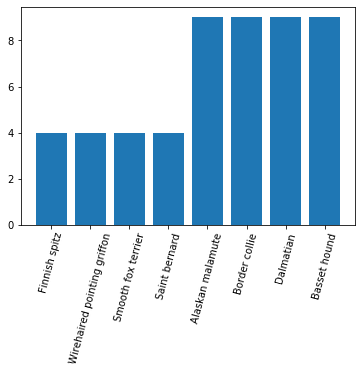

In [5]:
#Adding visualisation of the breed counts
plt.bar(df_diff_valid.Breed, df_diff_valid.train_count)
plt.xticks(rotation = 75)
plt.show()

From these results, it is clear that there is a bias towards Alaskan malamutes, border collies, etc.

This is due to there being more validation images and, therefore, an incentive to reduce the loss in these categories when compared to the validation set. As a result, images such as Saint Bernards are less likely to be represented by this model which may decrease the accuracy of the model in general.

However, the train data is the data which is used to actually change the weights. Wider patterns may still be captured for these images if there isn't a shortage in the training files:

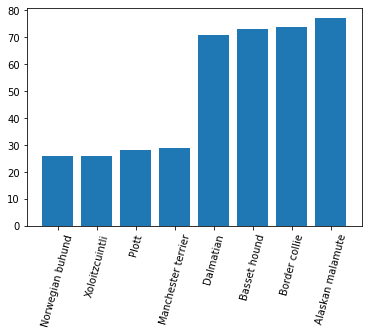

In [6]:
#REPEATING THE ABOVE FOR TRAIN FILES
#Creating a list of underlying paths and images
dog_train_paths = list(os.walk('../dogImages/train'))

#Removign the firt in the list as this is the directory itself
dog_train_paths.remove(dog_train_paths[0])

#Creating a mapping of breed to number of training files.
mapping_train = {}
for folder in dog_train_paths:
    dog_name = folder[0].split('\\')[-1].split('.')[-1]
    breed_count = len(folder[-1])
    
    mapping_train[dog_name] = breed_count
    
#Reading dictionary into a dataframe and reformating breed string
df_train = pd.DataFrame.from_dict(mapping_train, orient = 'index', columns = ['train_count'])\
                            .reset_index().rename({'index':'Breed'}, axis = 1)

df_train['Breed'] = df_train['Breed'].apply(lambda x : x.replace('_',' '))

#Taking the top and bottom 4 in terms of number of training files
df_bottom_4_train = df_train.sort_values(['train_count'], ascending = True)[:4]
df_top_4_train = df_train.sort_values(['train_count'], ascending = True)[-4:]
df_diff_train = pd.concat([df_bottom_4_train,df_top_4_train])

#Saving this locally
df_diff_train.to_pickle('model/Breed_Counts_train.pkl')

#Adding visualisation of the breed counts
plt.bar(df_diff_train.Breed, df_diff_train.train_count)
plt.xticks(rotation = 75)
plt.show()

It is clear from the combination of train files and validation files, that the model is much more tuned to dealing with Alaskan Malamutes than other breeds of dogs. The weights will be updated to minimise loss, which will be greater for differences in Malamutes. The validation set will then see a decrease in loss and these weights will be adopted, even though for the general case it may be less accurate.

## Investigation 2

I wanted to follow up on these biases and see what other impacts could be, I decided to look into Malamutes in particular

In [7]:
#Finding the folder number of Malamutes
Malamute_index = df_valid[df_valid.Breed == 'Alaskan malamute'].index[0]

#Retrieving the folder name this relates to
train_filepath = '../dogImages/valid'
Malamute_folder_name = os.listdir(train_filepath)[Malamute_index]
Malamute_folder = os.path.join(train_filepath,Malamute_folder_name)

#Getting all the image file paths
Malamute_img_names = os.listdir(Malamute_folder)
Malamute_img_paths = [os.path.join(train_filepath,Malamute_folder_name, filename) for filename in Malamute_img_names]

#Reading all these images
Malamute_imgs = [cv2.imread(image_path) for image_path in Malamute_img_paths]

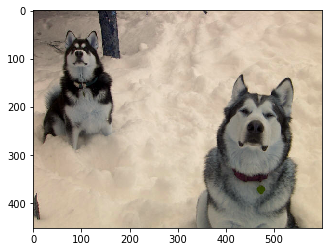

In [8]:
#Displaying the malamute images 1 at a time.
plt.imshow(Malamute_imgs[8])

Going through these images, there is no discernable pattern which I could make out. However, when looking at the background, it is clear that, in the validation set, lots of the images for Malamutes had snow in the background. As a result, when using in the general case, snow might be an indicator of a Malamute which may not be fully accurate

## Investigation 3
What is the reliability of the dog detector and the face detector

In [9]:
#Loading resnet model
ResNet50_model = ResNet50(weights='imagenet')

def path_to_tensor(img_path):
    """Takes a file path of an image, loads it and then extracts information into a fixed shape numpy 
    array, ready to be used for VGG19 feature extracrion.

    Parameters:
    img_path (String): Path to a file containing the image.

    Returns:
    (np.array): A numpy array with fixed dimensions and information from an image
    """
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def ResNet50_predict_labels(img_path):
    """Takes an image path, extracts information from it and uses the resnet model to classify the image

    Parameters:
    img_path (String): Path to a file containing the image.

    Returns:
    (Integer): A integer corresponding to the classification of the image
    """
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    
    return np.argmax(ResNet50_model.predict(img))

def dog_detector(img_path):
    """Takes a file path of an image and returns whether it is a dog or not

    Parameters:
    img_path (String): Path to a file containing the image.

    Returns:
    (Boolean): Presence of a dog
    """
    #USesresnet to predict category of image
    prediction = ResNet50_predict_labels(img_path)
    
    #Dogs are between the numbers returns below
    return ((prediction <= 268) & (prediction >= 151)) 

def face_detector(img_path):
    """Takes a file path of an image and detects whether a human face is present.

    Parameters:
    img_path (String): Path to a file containing the image.

    Returns:
    (Boolean): Presence of a human face
    """
    #Loads face classifier
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    
    #Reads in images and converts format
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #generates list of faces
    faces = face_cascade.detectMultiScale(gray)
    
    return len(faces) > 0

def load_dataset(path):
    """Loads all files from a path and returns it as file and labels
    
    Parameters:
    path (String): THis is a directory containing data required
    
    Returns:
    dog_files (np.array): arrays of file names loaded from the path
    dog_targets (np.array): Array of folder names (i.e. dog breed) relating to the files
    """
    #Loads in all files from path
    data = load_files(path)
    
    #Isolates all file and folder names within
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    
    return dog_files, dog_targets


#Loads in the train files and human files for comparisons
train_files, train_targets = load_dataset('../dogImages/train')
human_files = np.array(glob("../lfw/*/*"))

Taking a sample of the dataset loaded, we can get a rough idea of the accuracy relating to dog and human face detection:

In [10]:
#Loading a sample of the files
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

#Keeping track of the true positive / false positives.
human_count = 0
human_dogface_count = 0
dog_count = 0
dog_humanface_count =0

incorrect_dog = []
incorrect_human = []

#Looping through human files and detecting dogs/humans
for human in human_files_short:
    if dog_detector(human):
        human_dogface_count += 1
        incorrect_dog.append(human)
        
    if face_detector(human):
        human_count += 1

#Looping through dog files and detecting dogs/humans
for dog in dog_files_short:
    if dog_detector(dog):
        dog_count += 1
        
    if face_detector(dog):
        dog_humanface_count +=1
        incorrect_human.append(dog)
        
#Converting counts into accuracy metrics 
human_dog_accuracy = float(human_dogface_count) / float(len(human_files_short))
dog_dog_accuracy = float(dog_count) / float(len(dog_files_short))
human_dog_accuracy = "{0:.0%}".format(human_dog_accuracy)
dog_dog_accuracy = "{0:.0%}".format(dog_dog_accuracy)

human_human_accuracy = float(human_count) / float(len(human_files_short))
dog_human_accuracy = float(dog_humanface_count) / float(len(dog_files_short))
human_human_accuracy = "{0:.0%}".format(human_human_accuracy)
dog_human_accuracy = "{0:.0%}".format(dog_human_accuracy)


#Printing metrics
print("The dog detector incorrectly guessed %s of humans as a dog."%(human_dog_accuracy))    
print("The dog detector correctly guessed %s of dog faces."%(dog_dog_accuracy))
print("The face detector incorrectly guessed %s of dogs as humans."%(dog_human_accuracy))    
print("The face detector correctly guessed %s of human faces."%(human_human_accuracy))

The dog detector incorrectly guessed 0% of humans as a dog.
The dog detector correctly guessed 100% of dog faces.
The face detector incorrectly guessed 12% of dogs as humans.
The face detector correctly guessed 96% of human faces.


As can be seen above, the majority of the time, the face detector will detect a human face and the dog detector will detect the presence of the dog. This means the recall of this is quite high. However, the precision for the face detector is significantly less than the dog detector. 

89% precision rate for the human face detector, with 96% recall.
100% precision rate for the human face detector with 100% recall.

Below is a visualisation of the results

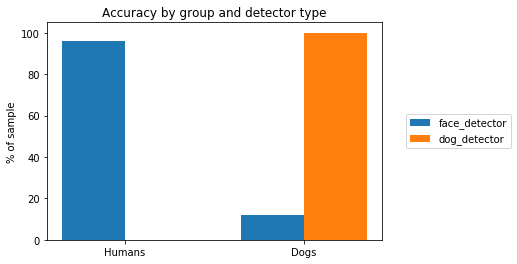

In [11]:
#Grouping human and dog values seperately
human_vals = (human_count, dog_humanface_count )
dog_vals = (human_dogface_count, dog_count)

#Saving these data figures
pickle.dump([human_vals,dog_vals],open('model/BarChart_1.pkl','wb+'))

#Plotting data relating to human and dogs.
fig, ax = plt.subplots()

ind = np.arange(2)    
width = 0.35

p1 = ax.bar(ind, human_vals, width,label='face_detector')
p2 = ax.bar(ind + width, dog_vals, width,label='dog_detector')

ax.set_title('Accuracy by group and detector type')
ax.set_ylabel('% of sample')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Humans', 'Dogs'))
ax.legend(loc='center right',bbox_to_anchor=(1.4, 0.50))

Now to investigate the cases where this was wrong:

In [12]:
#reading in files as image arrays
incorrect_human_img = [cv2.imread(file) for file in incorrect_human]
incorrect_dog_img = [cv2.imread(file) for file in incorrect_dog] #this is empty, i.e. no humans were classified as dogs

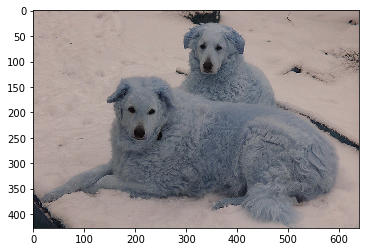

In [13]:
#GOIGN THROUGH SYSTEMATICALLY

plt.imshow(incorrect_human_img[0])


Some of the potential reasons for differences:

index 0: multiple dogs <br>
index 3: Dalmation patterns, also not clear / other bodies in the image <br>
index 5: Both a human and a dog in this photo<br>
index 6: Unclear/obscured face<br>
index 7: Multiple dogs<br>
index 9: Multiple dogs and dalmatian patterns<br>
index 10: Multiple dogs / edited image<br>
